In [ ]:
# Load necessary libraries
library(scales)
library(ggplot2)

In [ ]:
# Set options to avoid scientific notation
options(scipen = 999)

In [ ]:
install.packages("zoo")
library(zoo)  # For rollmean function
install.packages("corrplot")
library(corrplot)
library(dplyr)
install.packages("Synth")
library(Synth)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘nloptr’, ‘pracma’, ‘kernlab’, ‘optimx’, ‘rgenoud’


##
## Synth Package: Implements Synthetic Control Methods.


## See https://web.stanford.edu/~jhain/synthpage.html for additional information.





In [ ]:
# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_all_time_highers_lowers_undefined_All_Time_Highers",
  "mean_all_time_highers_lowers_undefined_All_Time_Lowers",
  "mean_average_time_between_transactions_Seconds",
  "mean_balance_by_time_held_undefined_Hodlers__1Y__",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_daily_active_addresses_Zero_Balance_Addresses",
  "mean_new_adoption_rate_New_Adoption_Rate"
)

In [ ]:
df <- read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT4a5agqu8qYF9iKC1d1PPhBmIWBtkRdOQrH4OQcEDYtKI__kR-jEmD_2u-wijSle6Nm_KPj5yFPiS4/pub?gid=157422852&single=true&output=csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_balance_by_time_held_undefined_Cruisers__1_12M_,mean_balance_by_time_held_undefined_Traders___1M_,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_daily_active_addresses_Zero_Balance_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ADA,2,2023-04-02,2023-04-05,0.01092283,0.3869143,754164.1,961455.3,1176457,1075012,⋯,16752171903,7359184734,17912.57,48408.00,16764.86,0.3699611,49988.86,41880117,4431851,37448266
2,ADA,2,2023-04-09,2023-04-12,0.01191549,0.4112000,735892.7,961096.7,1164975,1093435,⋯,16388929259,7795464258,19560.00,52910.00,19158.86,0.3700870,54512.71,42009249,4440325,37568924
3,ADA,2,2023-04-16,2023-04-19,0.01514539,0.4211643,727949.1,951395.7,1142862,1100409,⋯,16803748662,7435034001,18055.14,66782.00,29704.43,0.2840873,55687.71,42145472,4416116,37729356
4,ADA,2,2023-04-23,2023-04-26,0.01110080,0.3970571,742204.1,930132.0,1111400,1084364,⋯,15465931122,8910945215,16281.86,48214.14,17974.29,0.3428201,49313.57,42262244,4343732,37918512
5,ADA,2,2023-04-30,2023-05-03,0.01205666,0.3910357,745342.9,932077.0,1114531,1078214,⋯,16518302548,8055111937,18874.00,52322.43,18047.00,0.3601026,61652.86,42383568,4339567,38044002
6,ADA,2,2023-05-07,2023-05-10,0.01265736,0.3666929,769792.4,933612.7,1128868,1066932,⋯,17542569100,6964279418,21085.14,55084.29,19593.00,0.3805734,74135.29,42530752,4352094,38178658


## Choosing covariates and adding the week index

 [1] "mean_active_addresses_ratio_Active"                     
 [2] "cryptono"                                               
 [3] "mean_active_addresses_ratio_Price"                      
 [4] "mean_addresses_by_holdings_in_usd_X_0_00____1_00"       
 [5] "mean_addresses_by_holdings_in_usd_X_10_00____100_00"    
 [6] "mean_all_time_highers_lowers_undefined_All_Time_Highers"
 [7] "mean_all_time_highers_lowers_undefined_All_Time_Lowers" 
 [8] "mean_average_time_between_transactions_Seconds"         
 [9] "mean_balance_by_time_held_undefined_Hodlers__1Y__"      
[10] "mean_balance_by_time_held_undefined_Traders___1M_"      
[11] "mean_daily_active_addresses_Zero_Balance_Addresses"     
[12] "mean_new_adoption_rate_New_Adoption_Rate"               


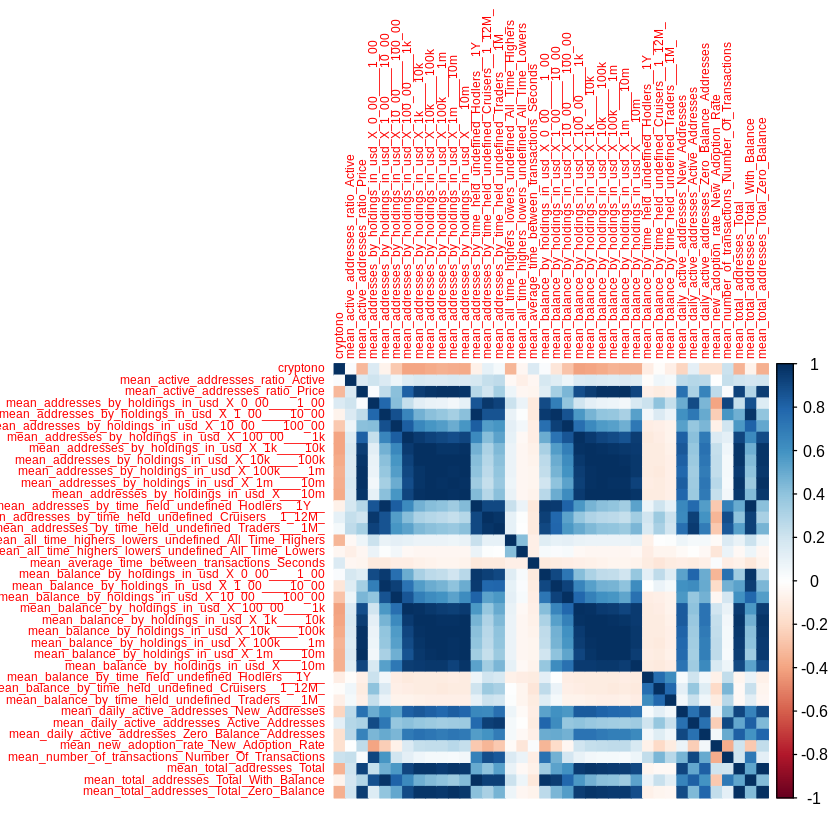

In [ ]:
# Calculate correlation matrix for all numeric predictors in the dataset
# Exclude non-numeric columns to get correlations only between numeric predictors
numeric_df <- df %>% select(where(is.numeric))
cor_matrix <- cor(numeric_df, use = "complete.obs")

# Visualize the correlation matrix to see how predictors correlate
corrplot(cor_matrix, method = "color", tl.cex = 0.6)


# Set the initial predictors list
predictors_list <- c(
  "mean_active_addresses_ratio_Active"
)

# Define a threshold for low correlation (adjust as necessary)
cor_threshold <- 0.7

# Function to add predictors with low correlation to existing predictors_list
add_predictors <- function(cor_matrix, predictors_list, cor_threshold) {
  for (col in colnames(cor_matrix)) {
    if (col %in% predictors_list) next  # Skip if already in predictors_list

    # Calculate maximum absolute correlation of this column with predictors in predictors_list
    max_cor <- max(abs(cor_matrix[col, predictors_list]), na.rm = TRUE)

    # Add to predictors_list if maximum correlation is below threshold
    if (max_cor < cor_threshold) {
      predictors_list <- c(predictors_list, col)
    }
  }
  return(predictors_list)
}

# Apply the function to extend the predictors_list
predictors_list <- add_predictors(cor_matrix, predictors_list, cor_threshold)

# Check the extended predictors_list
print(predictors_list)

In [ ]:
# Converting variables to the right type for dataprep
df$cryptono <- as.numeric(df$cryptono) # required by dataprep()
df$week <- as.Date(df$week, format="%Y-%m-%d")

# Create week index based on the earliest week
ref_date <- min(df$week) # Determine the reference date (the earliest week in the dataset)
df$week_index <- as.numeric(difftime(df$week, ref_date, units = "weeks")) + 1 # Create the week index
min(df$week)
print(max(df$week))
# Convert key dates to indices
dates <- as.Date(c("2024-04-21", "2023-04-02", "2024-09-22")) # Define the target dates
week_indices <- sapply(dates, function(date) {
  as.numeric(difftime(date, ref_date, units = "weeks")) + 1
}) # Calculate the number of weeks between the reference date and each target date
week_indices # Display the results

# 2023-04-02: 1 (min)
# 2024-04-21: 56 (halving)
# 2024-09-22: 78 (max)

[1] "2023-04-02"

[1] "2024-09-22"


[1] 56  1 78

### Rescaling price

In [ ]:
# Rescale `mean_active_addresses_ratio_Price` for each unit separately
df <- df %>%
  group_by(cryptono) %>%
  mutate(
    price_rescaled = (mean_active_addresses_ratio_Price - mean(mean_active_addresses_ratio_Price, na.rm = TRUE)) /
                     sd(mean_active_addresses_ratio_Price, na.rm = TRUE)
  ) %>%
  ungroup()

In [ ]:
head(df)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_daily_active_addresses_Zero_Balance_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,week_index,price_rescaled
<chr>,<dbl>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2,2023-04-02,2023-04-05,0.01092283,0.3869143,754164.1,961455.3,1176457,1075012,⋯,17912.57,48408.00,16764.86,0.3699611,49988.86,41880117,4431851,37448266,1,-0.18205744
ADA,2,2023-04-09,2023-04-12,0.01191549,0.4112000,735892.7,961096.7,1164975,1093435,⋯,19560.00,52910.00,19158.86,0.3700870,54512.71,42009249,4440325,37568924,2,0.01612350
ADA,2,2023-04-16,2023-04-19,0.01514539,0.4211643,727949.1,951395.7,1142862,1100409,⋯,18055.14,66782.00,29704.43,0.2840873,55687.71,42145472,4416116,37729356,3,0.09743597
ADA,2,2023-04-23,2023-04-26,0.01110080,0.3970571,742204.1,930132.0,1111400,1084364,⋯,16281.86,48214.14,17974.29,0.3428201,49313.57,42262244,4343732,37918512,4,-0.09928775
ADA,2,2023-04-30,2023-05-03,0.01205666,0.3910357,745342.9,932077.0,1114531,1078214,⋯,18874.00,52322.43,18047.00,0.3601026,61652.86,42383568,4339567,38044002,5,-0.14842497
ADA,2,2023-05-07,2023-05-10,0.01265736,0.3666929,769792.4,933612.7,1128868,1066932,⋯,21085.14,55084.29,19593.00,0.3805734,74135.29,42530752,4352094,38178658,6,-0.34707222


### Recoding as wallet value

In [ ]:
# Define the baseline week (minimum week in the dataset)
baseline_week <- "2023-04-02"

# Calculate initial holdings for each cryptocurrency based on the baseline week
df <- df %>%
  group_by(cryptono) %>%  # Group by each cryptocurrency
  arrange(week) %>%       # Ensure data is ordered by week within each group
  mutate(
    # Find the baseline price on the first week for each cryptocurrency
    baseline_price = first(mean_active_addresses_ratio_Price[week == baseline_week]),

    # Calculate the initial quantity bought with $100
    initial_quantity = 100 / baseline_price,

    # Calculate wallet value over time
    wallet_value = initial_quantity * mean_active_addresses_ratio_Price
  ) %>%
  ungroup()


In [ ]:
write.csv(df, "/content/sample_data/2024_recoded_rescaled.csv", row.names = FALSE)

## Model with Rescaled Price

In [ ]:
df <- read.csv("/content/sample_data/2024_recoded_rescaled (1).csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,total_holdings,mean_addresses_by_holdings_in_usd_X_0_00____1_00_share,mean_addresses_by_holdings_in_usd_X_1_00____10_00_share,mean_addresses_by_holdings_in_usd_X_10_00____100_00_share,mean_addresses_by_holdings_in_usd_X_100_00____1k_share,mean_addresses_by_holdings_in_usd_X_1k____10k_share,mean_addresses_by_holdings_in_usd_X_10k____100k_share,mean_addresses_by_holdings_in_usd_X_100k____1m_share,mean_addresses_by_holdings_in_usd_X_1m____10m_share,mean_addresses_by_holdings_in_usd_X___10m_share
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ADA,2,2023-04-02,2023-04-05,0.010922832,3.869143e-01,754164.143,961455.286,1176456.86,1075012.29,⋯,4432889.29,17.012925,21.689134,26.53928,24.2508264,8.7748252,1.5076526,0.201716230,0.018678563,0.0049629031
2,ALGO,3,2023-04-02,2023-04-05,0.001923339,2.181300e-01,16682932.140,237933.857,180843.43,141450.71,⋯,17291850.71,96.478581,1.375988,1.04583,0.8180195,0.2524583,0.0251134,0.002571814,0.001129351,0.0003081551
3,ANKR,4,2023-04-02,2023-04-05,0.006019269,3.522429e-02,3989.143,4761.286,18885.57,10815.86,⋯,41437.29,9.626941,11.490342,45.57628,26.1017510,6.1073360,0.7019213,0.285801952,0.094118134,0.0155139781
4,BTC,1,2023-04-02,2023-04-04,0.022138093,2.805625e+04,7369700.000,11077095.860,11280587.86,9252974.57,⋯,45938430.15,16.042560,24.112918,24.55588,20.1421218,10.7925997,3.6414541,0.554520784,0.146000076,0.0119417601
5,CRO,5,2023-04-02,2023-04-05,0.001342705,6.850929e-02,144844.429,53497.286,70341.57,22055.86,⋯,295395.43,49.034079,18.110397,23.81268,7.4665533,1.1758089,0.1042670,0.275611190,0.015862515,0.0047394098
6,ENJ,7,2023-04-02,2023-04-05,0.003946233,4.214143e-01,20945.286,24293.000,60483.57,43802.00,⋯,164834.57,12.706852,14.737806,36.69350,26.5733090,8.2825898,0.8349497,0.145947192,0.022446747,0.0026000094


In [ ]:
# New list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_all_time_highers_lowers_undefined_All_Time_Highers",
  "mean_all_time_highers_lowers_undefined_All_Time_Lowers",
  "mean_average_time_between_transactions_Seconds",
  "mean_balance_by_time_held_undefined_Hodlers__1Y__",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_daily_active_addresses_Zero_Balance_Addresses",
  "mean_new_adoption_rate_New_Adoption_Rate"
)

In [ ]:
# Count distinct cryptocurrencies
num_cryptos <- df %>%
  distinct(crypto) %>%
  nrow()

# Print the result
cat("Number of distinct cryptocurrencies:", num_cryptos, "\n")

Number of distinct cryptocurrencies: 24 



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.01745952 

solution.v:
 0.07144824 0.1575899 0.1652668 0.04867877 0.05785694 0.1105412 0.1256005 0.109897 0.1523346 0.0007860436 

solution.w:
 0.0000020696 0.0000003239 0.0000019436 0.0000005147 0.0000020925 0.3535438 0.3445347 0.0000021983 0.0000031491 0.0000002624 0.0000014111 0.0000070914 0.0000867813 0.0000024141 0.0000019422 0.0000020332 0.0000019435 0.0000022811 0.0000971349 0.0000021112 0.0000047809 0.0000029125 0.3016962 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_0_00____1_00         7470707.719
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12433206.189
mean_all_time_highers_lowers_undefined_All_Time_Highers   990046.673
mean_all_time_high

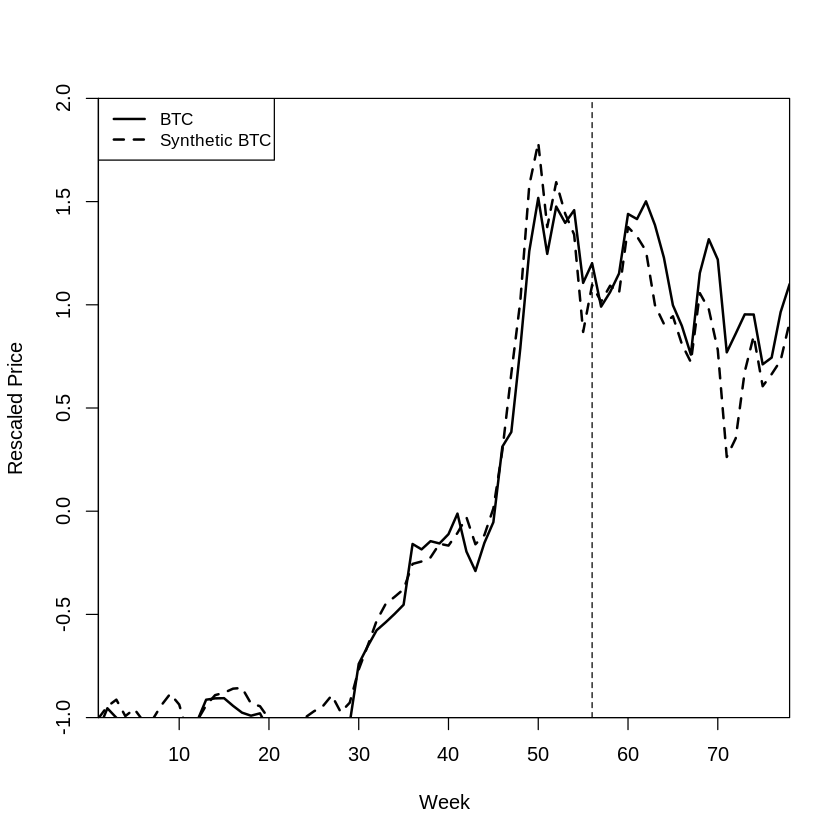

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_rescaled",  # Use the rescaled price
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Rescaled Price",
  Xlab = "Week",
  Ylim = c(-1,2),
  Legend = c("BTC", "Synthetic BTC"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

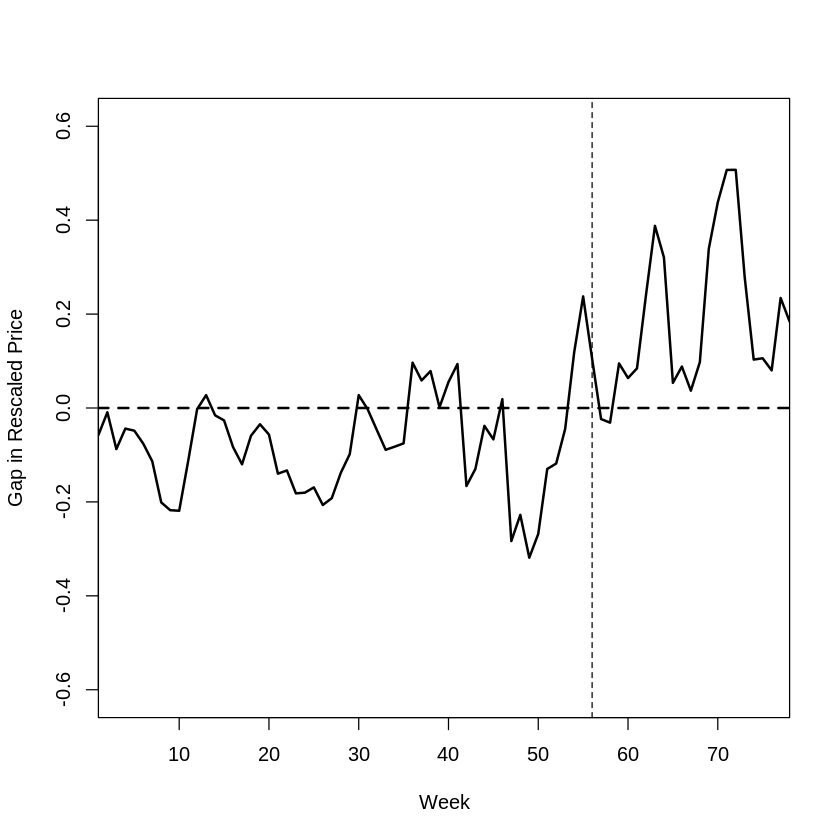

In [ ]:
# Gaps plot: shows difference between BTC and synthetic BTC over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Rescaled Price"),
  Xlab = c("Week"),
  Main = ""
)


abline(v   = 56,
       lty = 2)

## Model with Recoded Price (as a wallet value)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 39.47201 

solution.v:
 0.06578691 0.02131049 0.09105763 0.01014382 0.0228062 0.3564078 0.296022 0.1352117 0.00125344 

solution.w:
 0.0000000018 0.0000000063 0.0000000092 0.0000000007 0.0000000194 0.4739265 0.1014596 0.0000000196 0.0000000238 0.0000000001 0.0000000077 0.0000000263 0.0000000212 0.0000000219 0.000000014 0.0000000174 0.0000000125 0.0000000229 0.0000000032 0.0000000193 0.0000000211 0.0000000082 0.4246136 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_0_00____1_00         7470707.719
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12433206.189
mean_all_time_highers_lowers_undefined_All_Time_Highers   990046.673
mean_all_time_highers_lowers_und

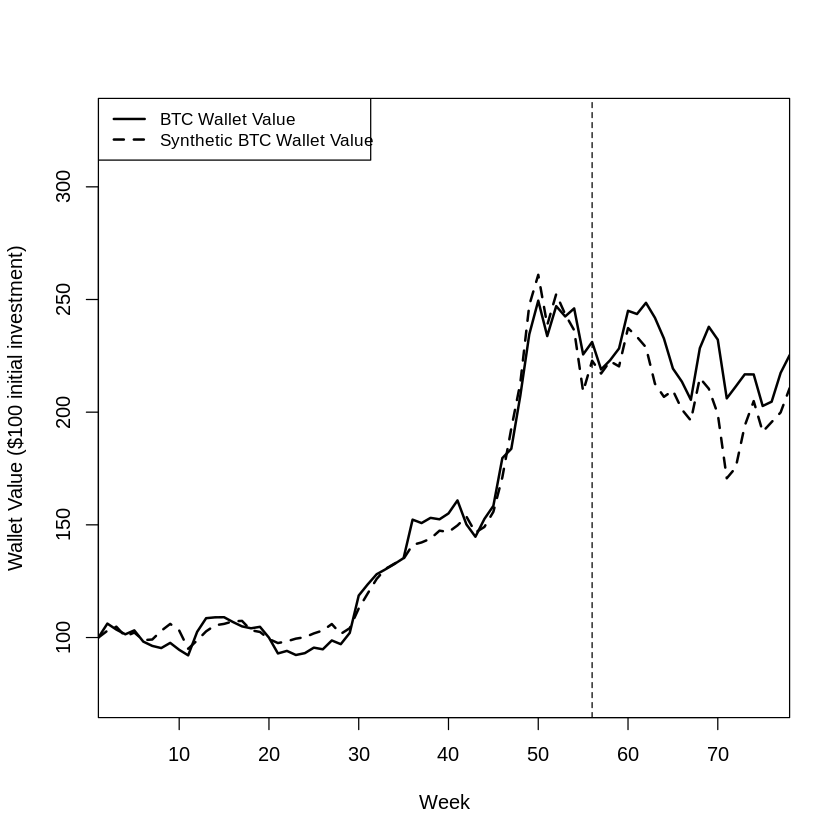

In [ ]:
# Define the key dates
#start_date <- as.Date("2023-04-02")  # Week 1
#halving_date <- as.Date("2024-04-21")  # Week 56
#end_date <- as.Date("2024-09-22")  # Week 78

# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

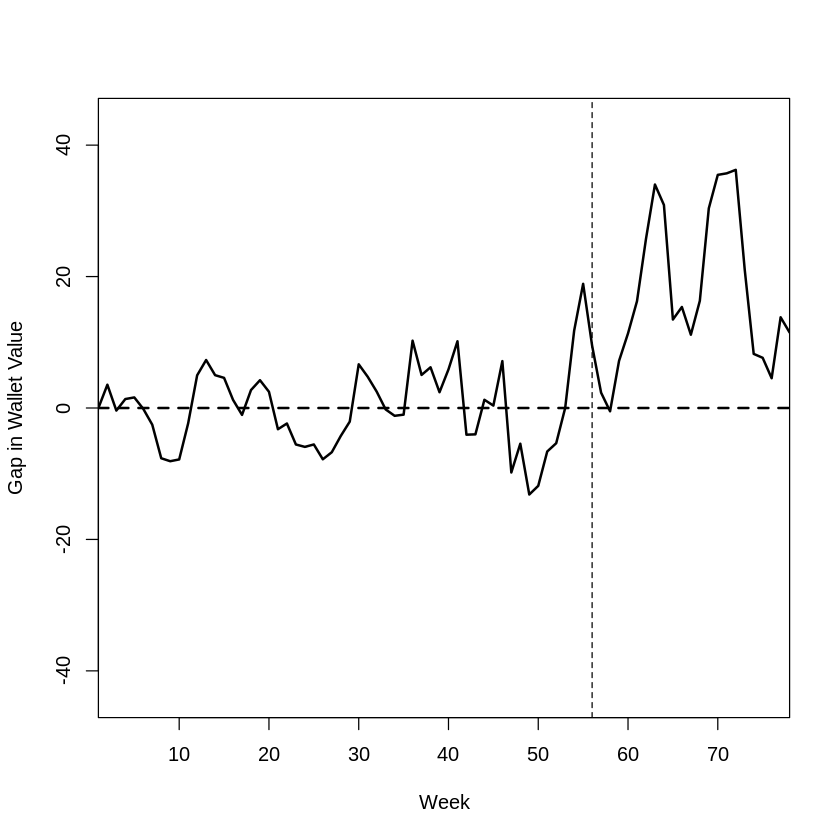

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 56,
       lty = 2)

In [ ]:
gaps<- dataprep.out$Y1plot-(
        dataprep.out$Y0plot%*%synth.out$solution.w
        ) ; gaps


,1
1,0.0000000002617213
2,3.5415523228915475
3,-0.3887729899468724
4,1.3630518991627554
5,1.6091065159471896
6,-0.1330008783454844
7,-2.5374164234230818
8,-7.6477257385627269
9,-8.0978415634383509
10,-7.8263868280880047


### Model without Number of Addresses by Holdings worth $0-1 USD and Hodler Balance, New Adoption Rate


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 36.44463 

solution.v:
 0.01306281 0.3752587 0.05124728 0.02930919 0.04458957 0.4303609 0.05617155 

solution.w:
 0.0000000012 0.0000000895 0.0000001853 0.0000002216 0.0000004278 0.4581767 0.09887607 0.0000004187 0.0000001253 0 0.0000002922 0.0000000047 0.000000173 0.0000003497 0.0000003047 0.0000004081 0.0000002489 0.0000003836 0.05476908 0.0000004898 0.000000453 0.000172743 0.3880008 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12433206.189
mean_all_time_highers_lowers_undefined_All_Time_Highers   990046.673
mean_all_time_highers_lowers_undefined_All_Time_Lowers     30370.901
mean_average_time_between_transactions_Seconds               593.

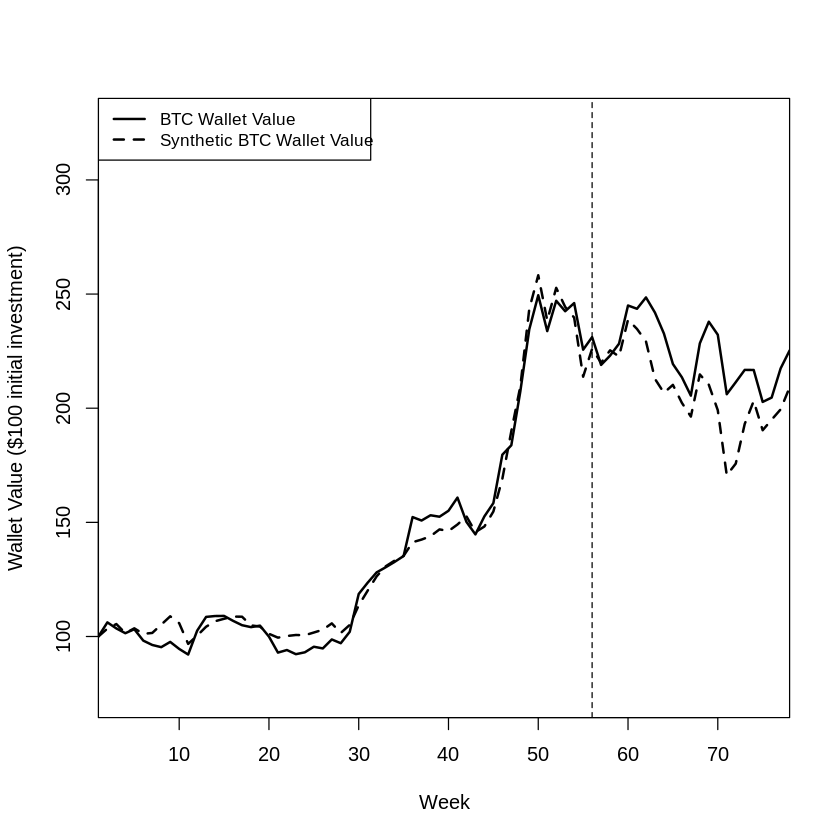

In [ ]:
# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_all_time_highers_lowers_undefined_All_Time_Highers",
  "mean_all_time_highers_lowers_undefined_All_Time_Lowers",
  "mean_average_time_between_transactions_Seconds",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_daily_active_addresses_Zero_Balance_Addresses"
)

# Define the key dates
#start_date <- as.Date("2023-04-02")  # Week 1
#halving_date <- as.Date("2024-04-21")  # Week 56
#end_date <- as.Date("2024-09-22")  # Week 78

# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

### Spaghetti Plots

In [ ]:
install.packages("SCtools")
library(SCtools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘DEoptimR’, ‘globals’, ‘listenv’, ‘parallelly’, ‘robustbase’, ‘future’, ‘cvTools’, ‘furrr’


Loading required package: future




Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard





X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 126.8535 

solution.v:
 0.0000132631 0.394773 0.009231054 0.01839037 0.006343027 0.02838242 0.001022839 0.0445108 0.4730045 0.02432876 

solution.w:
 0.00192416 0.01391288 0.00729225 0.006717625 0.002590109 0.0000148165 0.008731615 0.01483211 0.4808743 0.01748625 0.00986858 0.005431325 0.1591788 0.01721275 0.0000230721 0.1451879 0.01857719 0.009154128 0.007745408 0.01066784 0.02787368 0.03470322 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 1054.205 

solution.v:
 0.05561637 0.04765518 0.05331454 0.09497084 0.009267806 0.1667713 0.06163456 0.1532887 0.09069535 0.2667854 

solution.w:
 0.004334471 0.000752608 0.0000265212 0.001068576 0.2359322 0.0008372822 0.

New names:
• `w.weight` -> `w.weight...1`
• `w.weight` -> `w.weight...2`
• `w.weight` -> `w.weight...3`
• `w.weight` -> `w.weight...4`
• `w.weight` -> `w.weight...5`
• `w.weight` -> `w.weight...6`
• `w.weight` -> `w.weight...7`
• `w.weight` -> `w.weight...8`
• `w.weight` -> `w.weight...9`
• `w.weight` -> `w.weight...10`
• `w.weight` -> `w.weight...11`
• `w.weight` -> `w.weight...12`
• `w.weight` -> `w.weight...13`
• `w.weight` -> `w.weight...14`
• `w.weight` -> `w.weight...15`
• `w.weight` -> `w.weight...16`
• `w.weight` -> `w.weight...17`
• `w.weight` -> `w.weight...18`
• `w.weight` -> `w.weight...19`
• `w.weight` -> `w.weight...20`
• `w.weight` -> `w.weight...21`
• `w.weight` -> `w.weight...22`
• `w.weight` -> `w.weight...23`
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


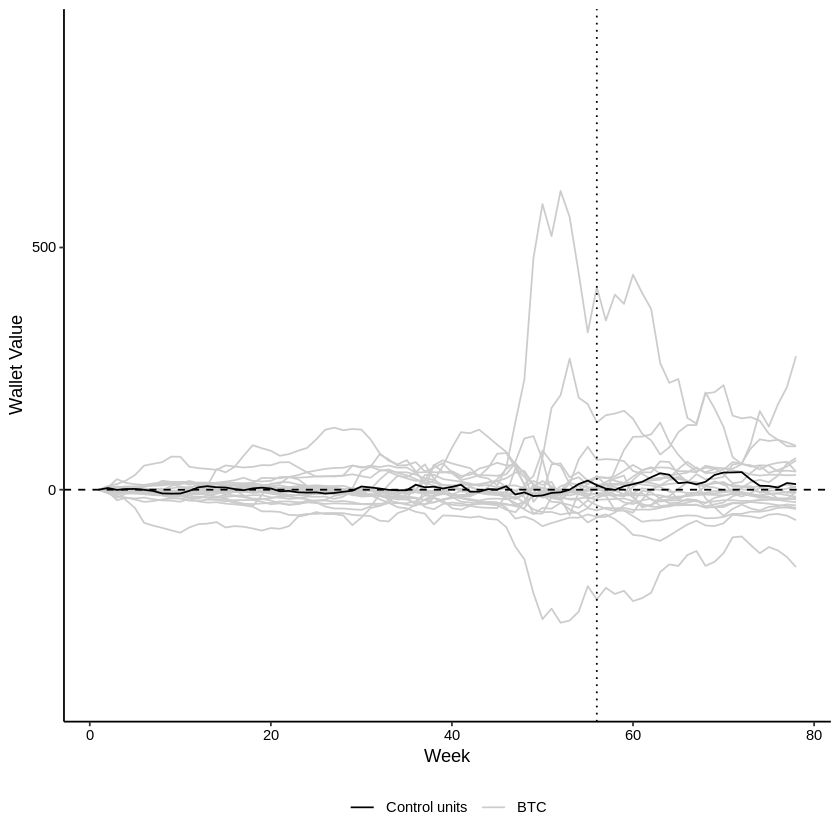

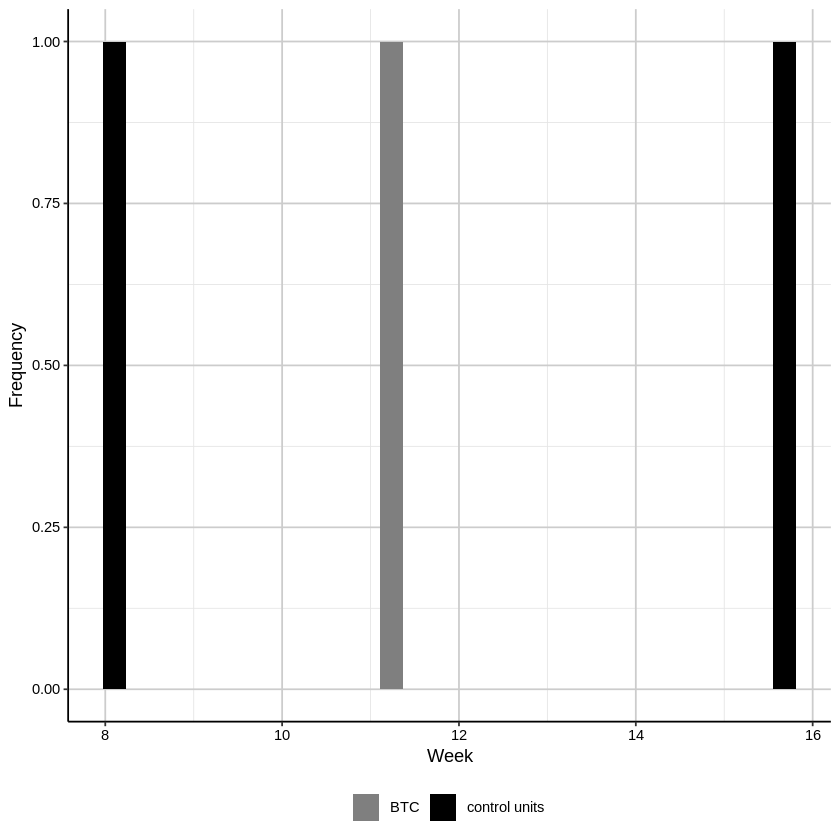

In [ ]:
placebos <- generate.placebos(dataprep.out, synth.out, Sigf.ipop = 3)
plot_placebos(placebos, xlab = "Week", ylab = "Wallet Value")
mspe.plot(placebos, discard.extreme = TRUE, mspe.limit = 1, plot.hist = TRUE, xlab = "Week", ylab = "Wallet Value")

In [ ]:
# Summarize wallet_value per cryptocurrency
wallet_value_summary <- df %>%
  group_by(crypto) %>%
  summarize(
    Mean = mean(wallet_value, na.rm = TRUE),
    Median = median(wallet_value, na.rm = TRUE),
    Min = min(wallet_value, na.rm = TRUE),
    Max = max(wallet_value, na.rm = TRUE),
    SD = sd(wallet_value, na.rm = TRUE),
    Count = n()
  )

# Output the summary
print(wallet_value_summary,n=24)

# A tibble: 24 × 7
   crypto  Mean Median   Min   Max    SD Count
   <chr>  <dbl>  <dbl> <dbl> <dbl> <dbl> <int>
 1 ADA    106.    99.6  63.8  189.  31.7    78
 2 ALGO    71.6   65.6  42.3  134.  21.5    78
 3 ANKR    84.9   74.4  52.0  165.  28.0    78
 4 BTC    162.   152.   92.1  249.  58.0    78
 5 CRO    125.   123.   73.6  227.  41.3    78
 6 ENJ     70.8   71.8  32.0  152.  23.8    78
 7 ETH    132.   124.   85.0  208.  37.5    78
 8 FET    264.   169.   52.8  836. 228.     78
 9 FTM     96.8   86.9  39.9  228.  45.9    78
10 GNO    175.   150.   83.2  361.  83.5    78
11 HOT     94.0   86.9  52.0  204.  32.4    78
12 IOTX   120.   113.   45.2  255.  55.8    78
13 KCS     99.2   99.3  48.0  179.  29.5    78
14 LEO    135.   119.  100    178.  29.1    78
15 LINK   162.   166.   72.0  281.  61.9    78
16 LPT    145.   104.   55.5  327.  78.3    78
17 MANA    69.5   70.1  42.4  121.  18.4    78
18 MATIC   65.0   63.8  34.7  106.  17.9    78
19 MKR    252.   221.   90.8  553. 116.  

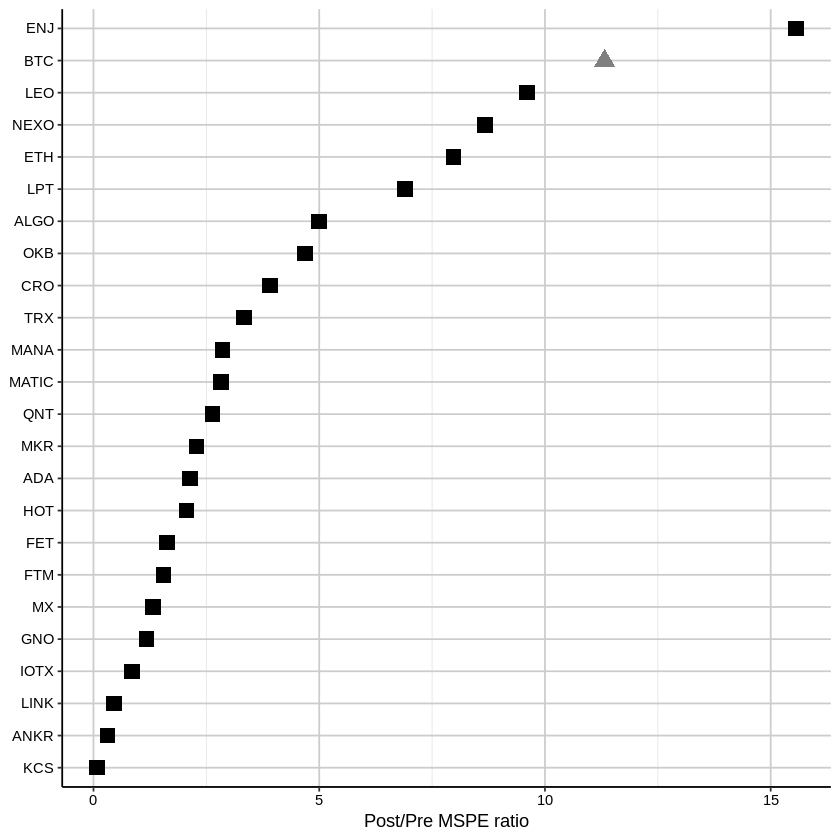

In [ ]:
mspe_plot(placebos)

In [ ]:
# Calculate the p-value
ratio <- mspe.test(placebos)
print(ratio$p.val)
print(ratio$test)

[1] 0.08333333
   MSPE.ratios  unit
1   2.13531859   ADA
2   4.99955809  ALGO
3   0.31688817  ANKR
4   3.90569919   CRO
5  15.55907347   ENJ
6   7.97895474   ETH
7   1.63112210   FET
8   1.54925610   FTM
9   1.17183755   GNO
10  2.06400132   HOT
11  0.85295872  IOTX
12  0.08118787   KCS
13  9.60081199   LEO
14  0.45591871  LINK
15  6.89816882   LPT
16  2.85793966  MANA
17  2.82109308 MATIC
18  2.28118870   MKR
19  1.31576967    MX
20  8.67402809  NEXO
21  4.68632980   OKB
22  2.63504831   QNT
23  3.32946817   TRX
24 11.32195393   BTC


### Model without FET


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 425.6334 

solution.v:
 0.01213687 0.3038752 0.2058025 0.003606283 0.0004616119 0.0006692602 0.09059599 0.09341173 0.2869108 0.00252978 

solution.w:
 0.0582801 1.11e-08 1.07e-07 3.54e-08 3.41e-07 0.3640009 3.032e-07 2.709e-07 1.26e-08 4.98e-08 5.02025e-05 1.261e-07 9.471e-07 4.7822e-06 4.3e-07 2.635e-07 2.594e-07 0.2916201 3.548e-07 4.658e-07 1.6833e-06 0.2860383 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_0_00____1_00         7470707.719
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12433206.189
mean_all_time_highers_lowers_undefined_All_Time_Highers   990046.673
mean_all_time_highers_lowers_undefined_All_Time_Lowers     30370.901
mean_average_time_

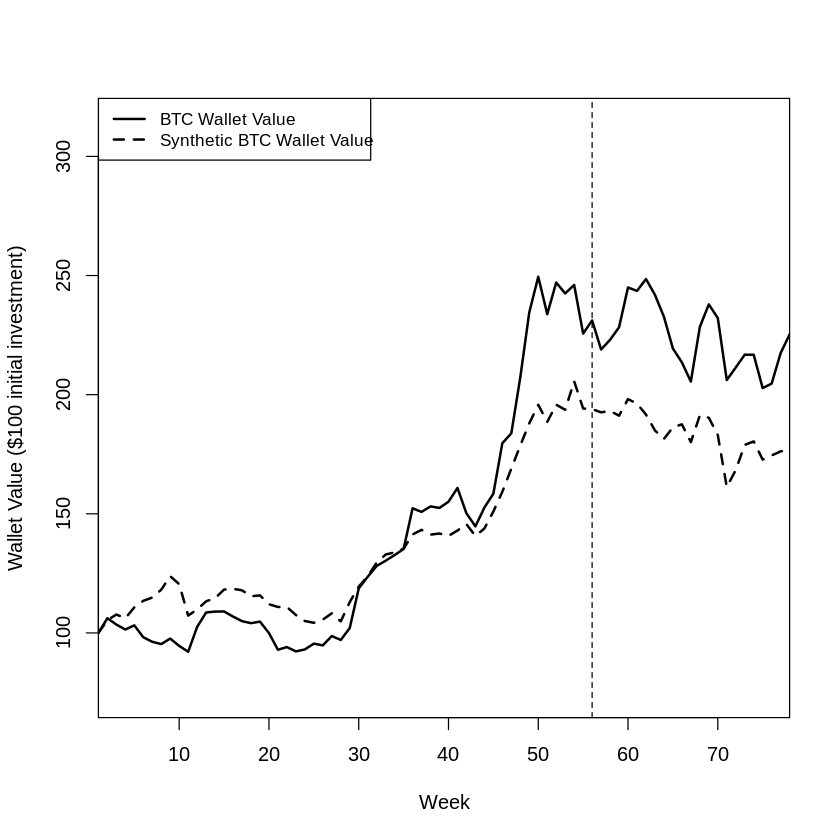

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14, 9) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

### Placebo in time: shifting 10 weeks back


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 19.89897 

solution.v:
 0.01309482 0.07999559 0.1008643 0.02965533 0.2633923 0.0325374 0.2483681 0.0561881 0.17234 0.003564089 

solution.w:
 0.0000000006 0.000000001 0.0000000019 0.0000000003 0.0000000207 0.3946173 0.1808353 0.000000017 0.0000000256 0.0000000001 0.0000000006 0.0000004926 0.0000011073 0.0000000252 0.0000000016 0.0000000162 0.0000000057 0.0000000154 0.0000007297 0.0000000222 0.0000000881 0.0000000176 0.4245448 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_0_00____1_00         7668630.606
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12282996.690
mean_all_time_highers_lowers_undefined_All_Time_Highers   679500.326
mean_all_time_highers_lo

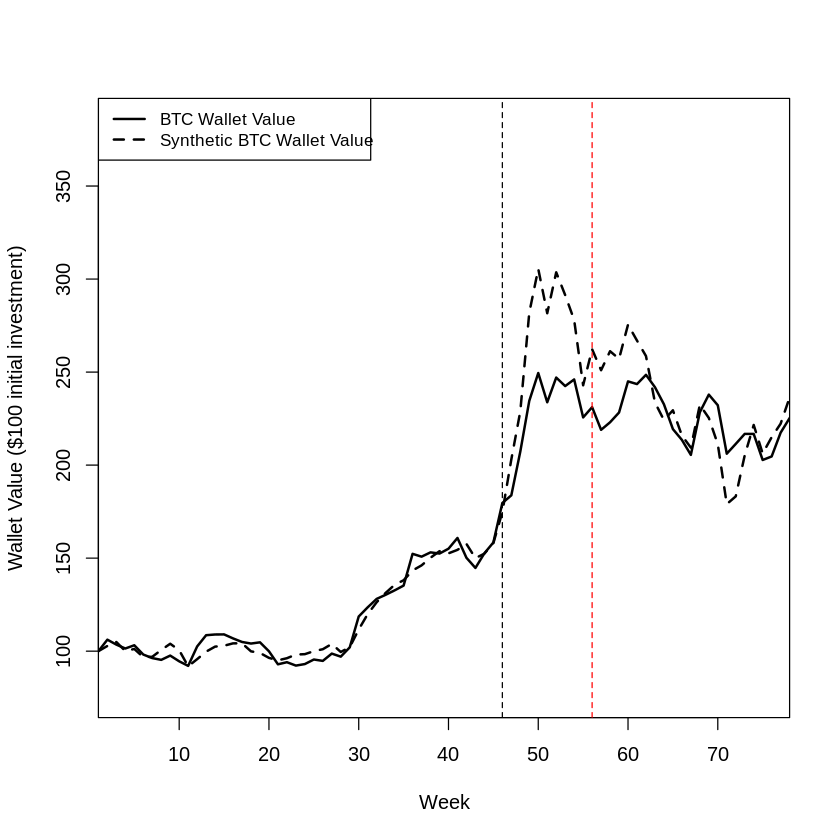

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:46)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 46,
       lty = 2)
abline(v   = 56,
       lty = 2, col="red")

### Placebo in time: 5 weeks back

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:49)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56, #47
       lty = 2)

### Placebo in space: treated unit now TRX (it had the largest weight)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 712.8759 

solution.v:
 0.7696629 0.0000462885 0.001622335 0.005039038 0.0002683427 0.1428792 0.07736669 0.003115225 

solution.w:
 0.815447 0.1845496 0.000000068 0.0000001258 0.0000000506 0.0000000687 0.000000099 0.000001254 0.0000000826 0.0000001175 0.000000026 0.0000002745 0.0000001158 0.0000000921 0.0000001109 0.0000000413 0.0000000682 0.0000000874 0.000000095 0.0000002659 0.0000000536 0.0000000643 0.0000002617 

$tab.pred
                                                               Treated
mean_active_addresses_ratio_Active                               0.020
mean_addresses_by_holdings_in_usd_X_10_00____100_00        2761137.117
mean_all_time_highers_lowers_undefined_All_Time_Highers     262352.028
mean_all_time_highers_lowers_undefined_All_Time_Lowers       97624.283
mean_average_time_between

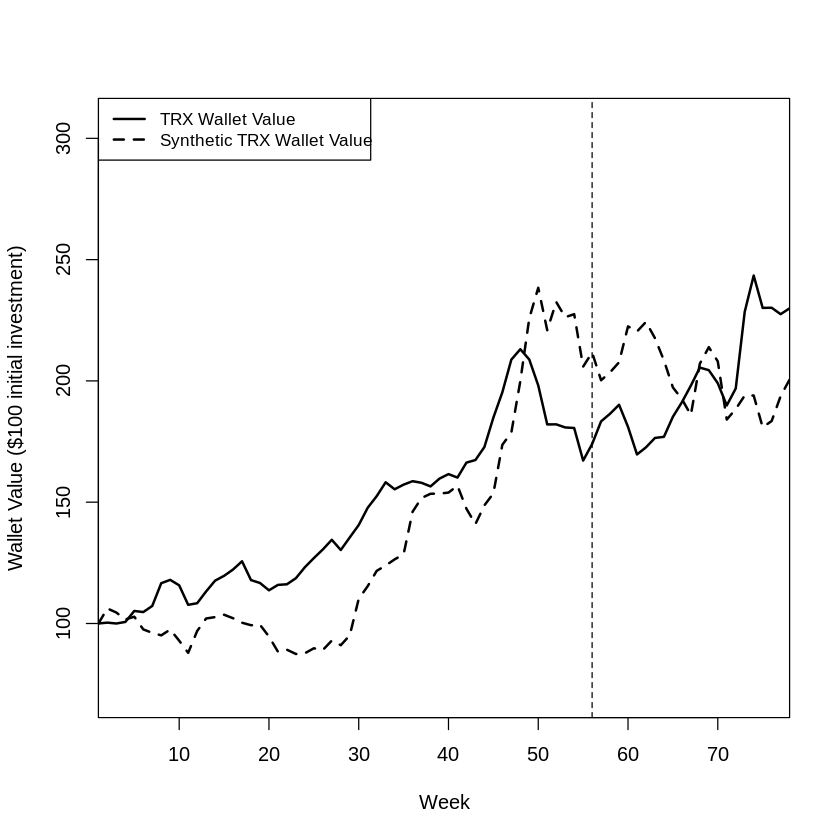

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(1:25) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 26,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("TRX Wallet Value", "Synthetic TRX Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

### Placebo in-space: Another unit: KCS #15


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 1119.474 

solution.v:
 0.002910823 0.05418503 0.1952751 0.2196952 0.04190572 0.08480668 0.0378036 0.08165538 0.1981938 0.08356869 

solution.w:
 0.01361428 1.3323e-06 3.9203e-06 4.012e-07 4.8032e-06 5.056e-07 3.177e-07 0.009197224 3.8e-07 1.758e-07 3.8351e-06 9.83e-08 0 3.537e-07 3.226e-07 4.4127e-06 4.5015e-06 1.96e-07 1e-10 1.0932e-06 0.9771614 2.344e-07 2.149e-07 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                      5.000000e-03
mean_addresses_by_holdings_in_usd_X_0_00____1_00        4.476030e+02
mean_addresses_by_holdings_in_usd_X_10_00____100_00     2.991130e+03
mean_all_time_highers_lowers_undefined_All_Time_Highers 8.336500e+01
mean_all_time_highers_lowers_undefined_All_Time_Lowers  1.405431e+03
mean_average_ti

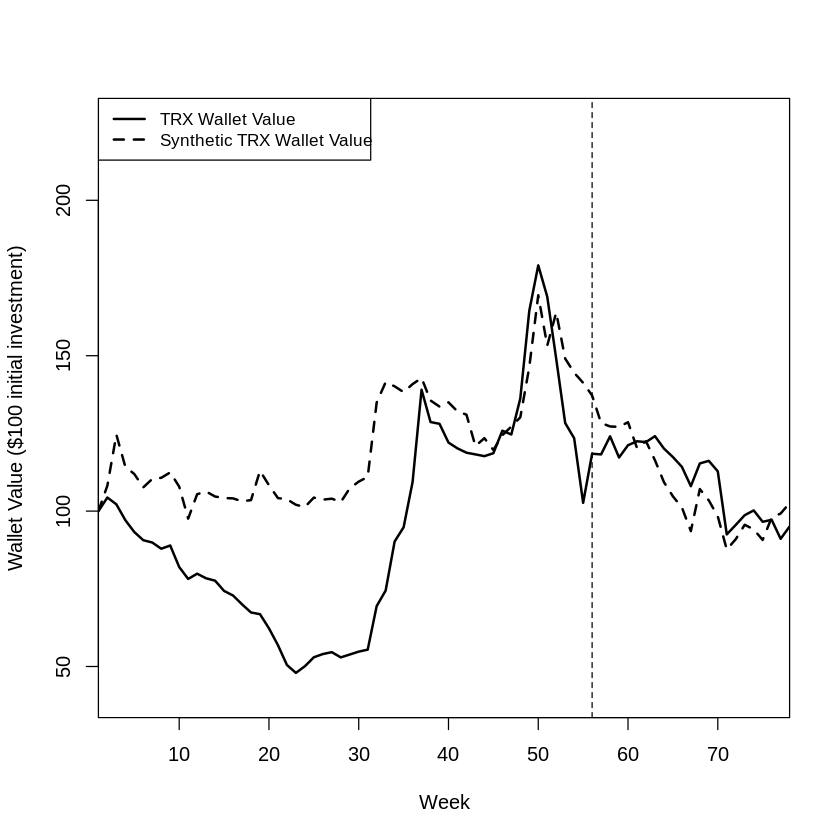

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 15) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 15,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("TRX Wallet Value", "Synthetic TRX Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

### Different Variable: DV = mean_average_time_between_transactions_Seconds


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 74051.09 

solution.v:
 0.1047114 0.1448108 0.0627054 0.05617911 0.1015854 0.1522422 0.1390107 0.01934323 0.2194118 

solution.w:
 0.0000000016 0.0000000013 0.0000000005 0.0000000019 0.0000000006 0.08407352 0.8257752 0.0000000005 0.0000000003 0.000000003 0.0000000001 0.08903706 0.0000000004 0.0000000004 0.0000000004 0.0000000008 0.0000000008 0.0000000003 0.0000000004 0.0000000008 0.000000001 0.0000000002 0.001114196 

$tab.pred
                                                             Treated
mean_active_addresses_ratio_Active                             0.019
mean_addresses_by_holdings_in_usd_X_0_00____1_00         7470707.719
mean_addresses_by_holdings_in_usd_X_10_00____100_00     12433206.189
mean_all_time_highers_lowers_undefined_All_Time_Highers   990046.673
mean_all_time_highers_lowers_undef

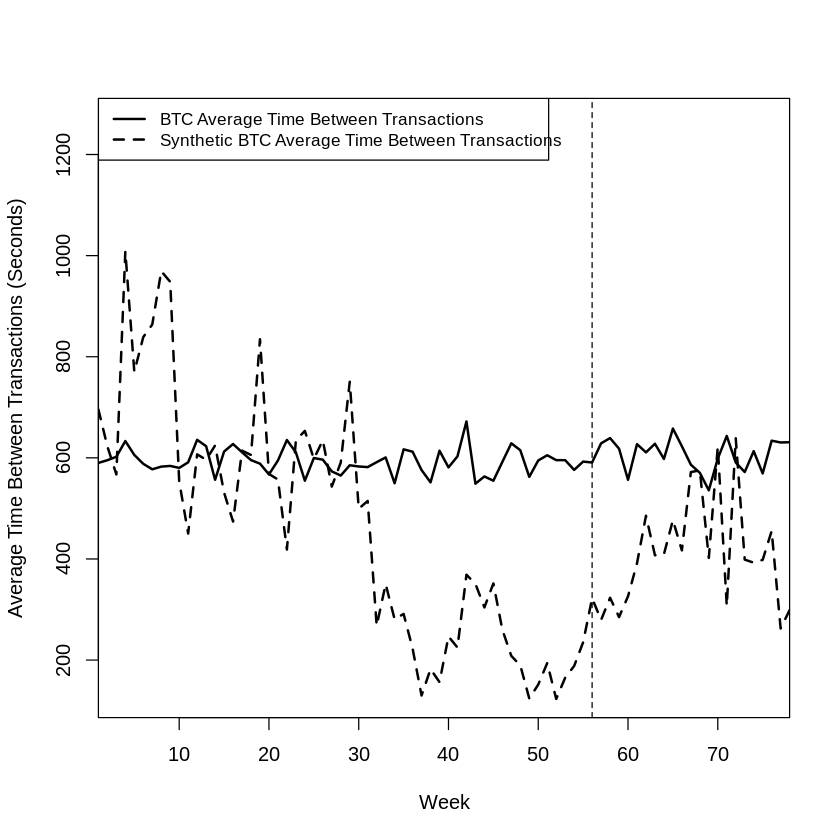

In [ ]:
# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_all_time_highers_lowers_undefined_All_Time_Highers",
  "mean_all_time_highers_lowers_undefined_All_Time_Lowers",
  "mean_balance_by_time_held_undefined_Hodlers__1Y__",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_daily_active_addresses_Zero_Balance_Addresses",
  "mean_new_adoption_rate_New_Adoption_Rate"
)

# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_average_time_between_transactions_Seconds",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Average Time Between Transactions (Seconds)",
  Xlab = "Week",
  Legend = c("BTC Average Time Between Transactions", "Synthetic BTC Average Time Between Transactions"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

# BTC vs Average Price of Others

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


[1] "Other cryptocurrencies:"
   crypto
1     ADA
2    ALGO
3    ANKR
4     CRO
5     ENJ
6     ETH
7     FET
8     FTM
9     GNO
10    HOT
11   IOTX
12    KCS
13    LEO
14   LINK
15    LPT
16   MANA
17  MATIC
18    MKR
19     MX
20   NEXO
21    OKB
22    QNT
23    TRX
[1] "Other cryptos average price:"
# A tibble: 78 × 2
   week_index mean_price
        <int>      <dbl>
 1          1       124.
 2          2       130.
 3          3       133.
 4          4       125.
 5          5       126.
 6          6       121.
 7          7       119.
 8          8       119.
 9          9       123.
10         10       121.
# ℹ 68 more rows


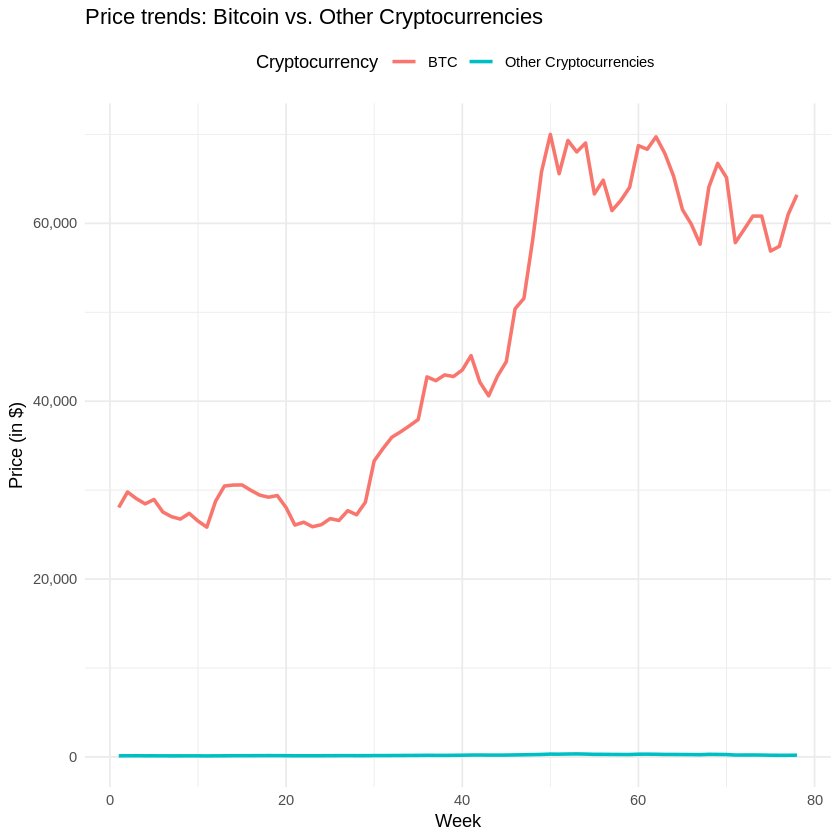

In [ ]:
# Load the dataset
df <- read.csv("/content/sample_data/2024_recoded_rescaled.csv")

# Define the time periods (same as the synthetic control plot)
time_plot <- c(1:78)

# Filter the data to include only the weeks in the time_plot range
df_filtered <- df %>%
  filter(week_index %in% time_plot)

# Extract BTC data
btc_data <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(week_index, mean_active_addresses_ratio_Price)

# Compute the average mean_active_addresses_ratio_Price for other cryptocurrencies
other_crypto_avg <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(week_index) %>%
  summarize(mean_price = mean(mean_active_addresses_ratio_Price, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data <- btc_data %>%
  mutate(group = "BTC")

other_plot_data <- other_crypto_avg %>%
  rename(mean_active_addresses_ratio_Price = mean_price) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data <- bind_rows(btc_plot_data, other_plot_data)

# Create the plot
ggplot(plot_data, aes(x = week_index, y = mean_active_addresses_ratio_Price, color = group)) +
  geom_line(size = 1) +
  labs(
    title = "Price trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Week",
    y = "Price (in $)",
    color = "Cryptocurrency"
  ) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

# Filter and get the unique cryptocurrencies excluding BTC
other_cryptos <- df %>%
  filter(crypto != "BTC") %>%
  distinct(crypto) %>%
  arrange(crypto)

# Output the list of other cryptocurrencies
print("Other cryptocurrencies:")
print(other_cryptos)
print("Other cryptos average price:")
print(other_crypto_avg)

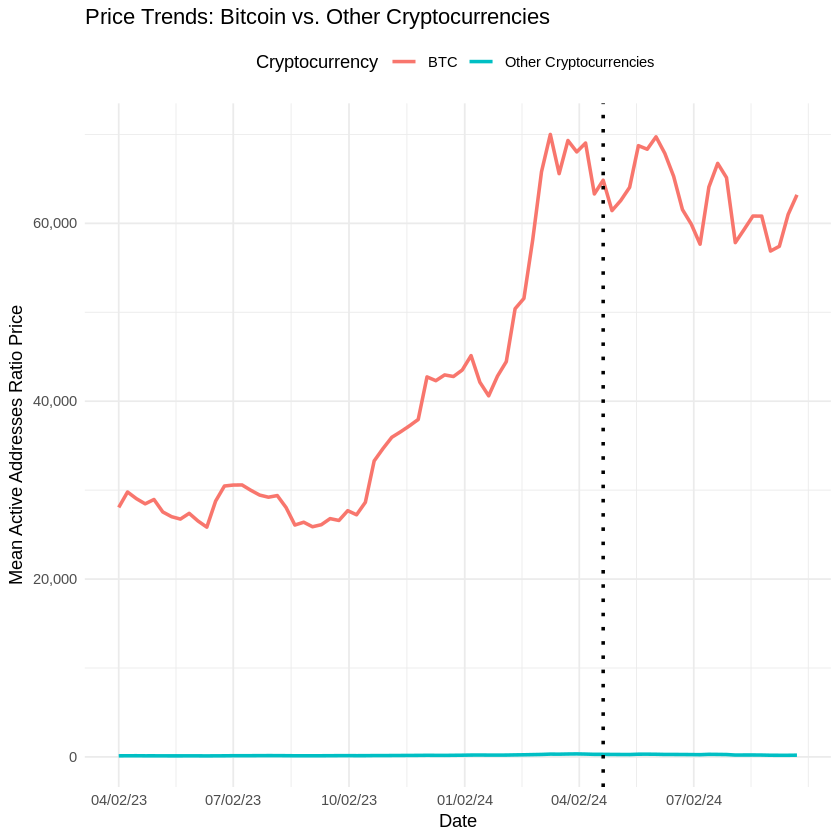

In [ ]:
# Load the dataset
df <- read.csv("/content/sample_data/2024_recoded_rescaled.csv")

# Define key dates and week ranges
start_date <- as.Date("2023-04-02")  # Corresponding to week_index = 1
halving_date <- as.Date("2024-04-21")  # Corresponding to week_index = 56
end_date <- as.Date("2024-09-22")  # Corresponding to week_index = 78

# Add a date column based on week_index
df <- df %>%
  mutate(date = start_date + (week_index - 1) * 7)  # Convert weeks to dates

# Define the time periods
time_plot <- seq(start_date, end_date, by = "week")

# Filter the data to include only the weeks in the time_plot range
df_filtered <- df %>%
  filter(date %in% time_plot)

# Extract BTC data
btc_data <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(date, mean_active_addresses_ratio_Price)

# Compute the average mean_active_addresses_ratio_Price for other cryptocurrencies
other_crypto_avg <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(date) %>%
  summarize(mean_price = mean(mean_active_addresses_ratio_Price, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data <- btc_data %>%
  mutate(group = "BTC")

other_plot_data <- other_crypto_avg %>%
  rename(mean_active_addresses_ratio_Price = mean_price) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data <- bind_rows(btc_plot_data, other_plot_data)

# Create the plot
ggplot(plot_data, aes(x = date, y = mean_active_addresses_ratio_Price, color = group)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(halving_date), linetype = "dotted", color = "black", size = 1) +
  labs(
    title = "Price Trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Date",
    y = "Mean Active Addresses Ratio Price",
    color = "Cryptocurrency"
  ) +
  scale_x_date(date_labels = "%m/%d/%y", breaks = seq(start_date, end_date, by = "3 months")) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

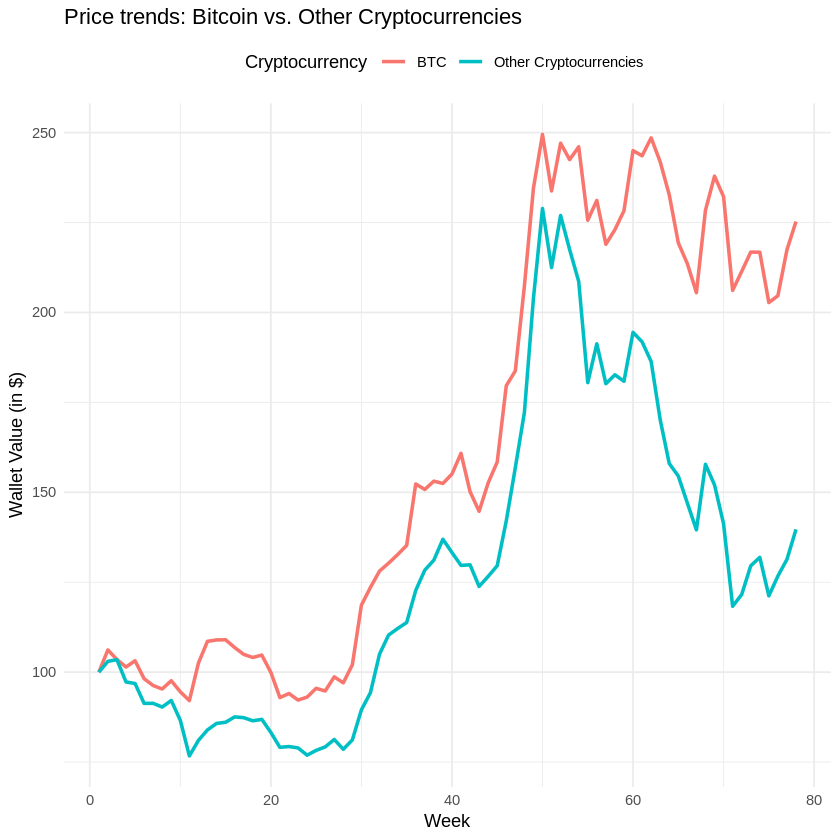

In [ ]:
# Extract BTC wallet value data
btc_data_wallet_value <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(week_index, wallet_value)

# Compute the average wallet_value for other cryptocurrencies
other_crypto_avg_wallet_value <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(week_index) %>%
  summarize(mean_wallet_value = mean(wallet_value, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data_wallet_value <- btc_data_wallet_value %>%
  mutate(group = "BTC")

other_plot_data_wallet_value <- other_crypto_avg_wallet_value %>%
  rename(wallet_value = mean_wallet_value) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data_wallet_value <- bind_rows(btc_plot_data_wallet_value, other_plot_data_wallet_value)

# Create the plot
ggplot(plot_data_wallet_value, aes(x = week_index, y = wallet_value, color = group)) +
  geom_line(size = 1) +
  labs(
    title = "Price trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Week",
    y = "Wallet Value (in $)",
    color = "Cryptocurrency"
  ) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

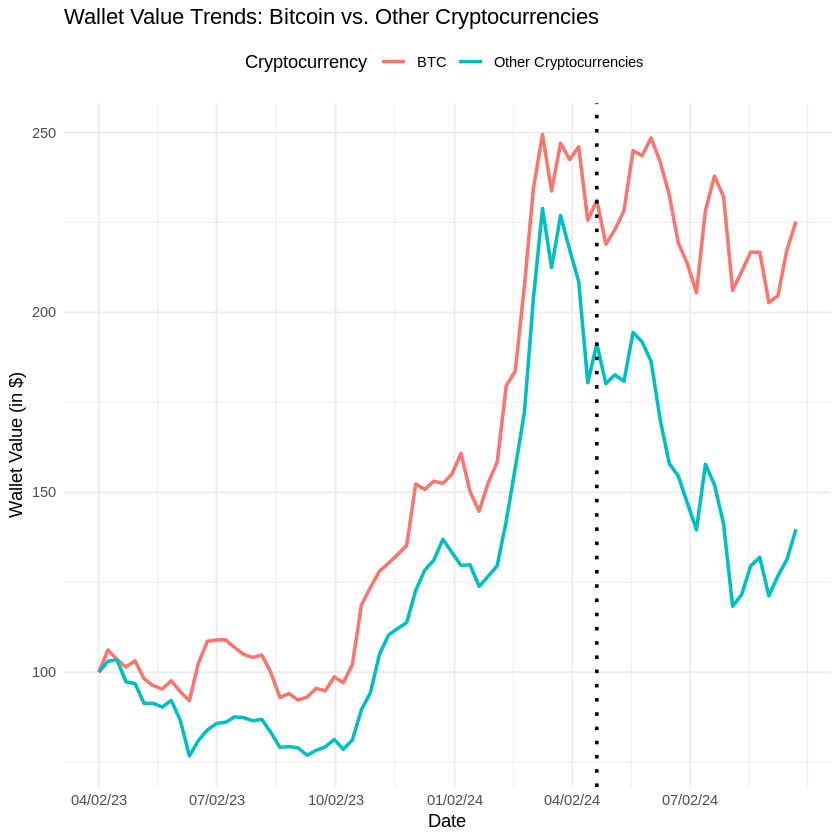

In [ ]:
# Add a date column based on week_index
df_filtered <- df_filtered %>%
  mutate(date = start_date + (week_index - 1) * 7)  # Convert week_index to dates

# Extract BTC wallet value data
btc_data_wallet_value <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(date, wallet_value)

# Compute the average wallet_value for other cryptocurrencies
other_crypto_avg_wallet_value <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(date) %>%
  summarize(mean_wallet_value = mean(wallet_value, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data_wallet_value <- btc_data_wallet_value %>%
  mutate(group = "BTC")

other_plot_data_wallet_value <- other_crypto_avg_wallet_value %>%
  rename(wallet_value = mean_wallet_value) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data_wallet_value <- bind_rows(btc_plot_data_wallet_value, other_plot_data_wallet_value)

# Create the plot
ggplot(plot_data_wallet_value, aes(x = date, y = wallet_value, color = group)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(halving_date), linetype = "dotted", color = "black", size = 1) +
  labs(
    title = "Wallet Value Trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Date",
    y = "Wallet Value (in $)",
    color = "Cryptocurrency"
  ) +
  scale_x_date(date_labels = "%m/%d/%y", breaks = seq(start_date, end_date, by = "3 months")) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

# Recoded price (wallet value): Normalized Predictors

In [ ]:
df <- read.csv("/content/sample_data/2024_recoded_rescaled.csv")
head(df)

In [ ]:
# Define the columns representing the holdings brackets
holdings_columns <- c(
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_addresses_by_holdings_in_usd_X_100_00____1k",
  "mean_addresses_by_holdings_in_usd_X_1k____10k",
  "mean_addresses_by_holdings_in_usd_X_10k____100k",
  "mean_addresses_by_holdings_in_usd_X_100k____1m",
  "mean_addresses_by_holdings_in_usd_X_1m____10m",
  "mean_addresses_by_holdings_in_usd_X___10m"
)

# Add "_share" columns for each bracket
df <- df %>%
  rowwise() %>%
  mutate(
    total_holdings = sum(c_across(all_of(holdings_columns)), na.rm = TRUE),
    across(
      all_of(holdings_columns),
      .fns = ~ 100 * .x / total_holdings,
      .names = "{.col}_share"
    )
  ) %>%
  ungroup()

# Add logged variables and calculate the share of highers to lowers
df <- df %>%
  mutate(
    # Add logged variables (adding 1 to avoid issues with log(0))
    log_all_time_highers = log(mean_all_time_highers_lowers_undefined_All_Time_Highers + 1),
    log_all_time_lowers = log(mean_all_time_highers_lowers_undefined_All_Time_Lowers + 1),
    log_avg_time_between_transactions = log(mean_average_time_between_transactions_Seconds + 1),
    log_hodler_balance = log(mean_balance_by_time_held_undefined_Hodlers__1Y__ + 1),

    # Calculate the share of highers to lowers
    share_highers_to_lowers = mean_all_time_highers_lowers_undefined_All_Time_Highers /
                              mean_all_time_highers_lowers_undefined_All_Time_Lowers
  )

# Create shares for Hodlers, Cruisers, and Traders
df <- df %>%
  mutate(
    # Calculate the total balance for the three groups
    total_balance_by_time_held = mean_balance_by_time_held_undefined_Hodlers__1Y__ +
                                 mean_balance_by_time_held_undefined_Cruisers__1_12M_ +
                                 mean_balance_by_time_held_undefined_Traders___1M_,

    # Calculate shares
    mean_balance_by_time_held_undefined_Hodlers__1Y___share = mean_balance_by_time_held_undefined_Hodlers__1Y__ / total_balance_by_time_held,
    mean_balance_by_time_held_undefined_Cruisers__1_12M__share = mean_balance_by_time_held_undefined_Cruisers__1_12M_ / total_balance_by_time_held,
    mean_balance_by_time_held_undefined_Traders___1M__share = mean_balance_by_time_held_undefined_Traders___1M_ / total_balance_by_time_held
  )

# Add addresses share variables
df <- df %>%
  mutate(
    # Calculate the share of zero balance addresses out of total addresses
    mean_total_addresses_Total_Zero_Balance_share = mean_total_addresses_Total_Zero_Balance / mean_total_addresses_Total,

    # Calculate the share of addresses with balance out of total addresses
    mean_total_addresses_Total_With_Balance_share = mean_total_addresses_Total_With_Balance / mean_total_addresses_Total,

    # Calculate the share of zero balance daily active addresses out of total daily active addresses
    mean_daily_active_addresses_Zero_Balance_Addresses_share = mean_daily_active_addresses_Zero_Balance_Addresses / mean_daily_active_addresses_Active_Addresses
  )



# Check the structure of the updated dataframe
head(df)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,log_avg_time_between_transactions,log_hodler_balance,share_highers_to_lowers,total_balance_by_time_held,mean_balance_by_time_held_undefined_Hodlers__1Y___share,mean_balance_by_time_held_undefined_Cruisers__1_12M__share,mean_balance_by_time_held_undefined_Traders___1M__share,mean_total_addresses_Total_Zero_Balance_share,mean_total_addresses_Total_With_Balance_share,mean_daily_active_addresses_Zero_Balance_Addresses_share
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2,2023-04-02,2023-04-05,0.010922832,0.38691429,754164.143,961455.286,1176456.86,1075012.29,⋯,3.133192,22.98627,4.7598600,33723288600,0.2850236,0.49675380,0.21822263,0.8941777,0.10582232,0.34632410
ALGO,3,2023-04-02,2023-04-05,0.001923339,0.21812995,16682932.140,237933.857,180843.43,141450.71,⋯,1.555759,21.62486,62.2612722,10004740128,0.2462361,0.59461401,0.15914987,0.4256921,0.57430793,0.03812657
ANKR,4,2023-04-02,2023-04-05,0.006019269,0.03522429,3989.143,4761.286,18885.57,10815.86,⋯,5.638495,21.72790,0.6554542,10000094086,0.2730878,0.57325000,0.15366216,0.7360583,0.26394174,0.21228070
BTC,1,2023-04-02,2023-04-04,0.022138093,28056.25143000,7369700.000,11077095.860,11280587.86,9252974.57,⋯,6.381782,16.38048,23.9312746,19339399,0.6722169,0.23851022,0.08927289,0.9603174,0.03968263,0.48041136
CRO,5,2023-04-02,2023-04-05,0.001342705,0.06850929,144844.429,53497.286,70341.57,22055.86,⋯,5.382633,25.26157,0.9256645,100000268960,0.9353189,0.04764353,0.01703755,0.4381714,0.56182863,0.23186292
ENJ,7,2023-04-02,2023-04-05,0.003946233,0.42141429,20945.286,24293.000,60483.57,43802.00,⋯,4.885928,19.86416,0.6003316,1000090704,0.4235025,0.49172270,0.08477479,0.7040939,0.29590607,0.34646556


In [ ]:
# If needed, saving again after transformations
write.csv(df, "/content/sample_data/2024_recoded_rescaled.csv (1)", row.names = FALSE)

 [1] "mean_active_addresses_ratio_Active"                       
 [2] "cryptono"                                                 
 [3] "mean_active_addresses_ratio_Price"                        
 [4] "mean_addresses_by_holdings_in_usd_X_0_00____1_00"         
 [5] "mean_addresses_by_holdings_in_usd_X_10_00____100_00"      
 [6] "mean_all_time_highers_lowers_undefined_All_Time_Highers"  
 [7] "mean_all_time_highers_lowers_undefined_All_Time_Lowers"   
 [8] "mean_average_time_between_transactions_Seconds"           
 [9] "mean_balance_by_time_held_undefined_Hodlers__1Y__"        
[10] "mean_balance_by_time_held_undefined_Traders___1M_"        
[11] "mean_daily_active_addresses_Zero_Balance_Addresses"       
[12] "mean_new_adoption_rate_New_Adoption_Rate"                 
[13] "week_index"                                               
[14] "price_rescaled"                                           
[15] "wallet_value"                                             
[16] "mean_addresses_by_h

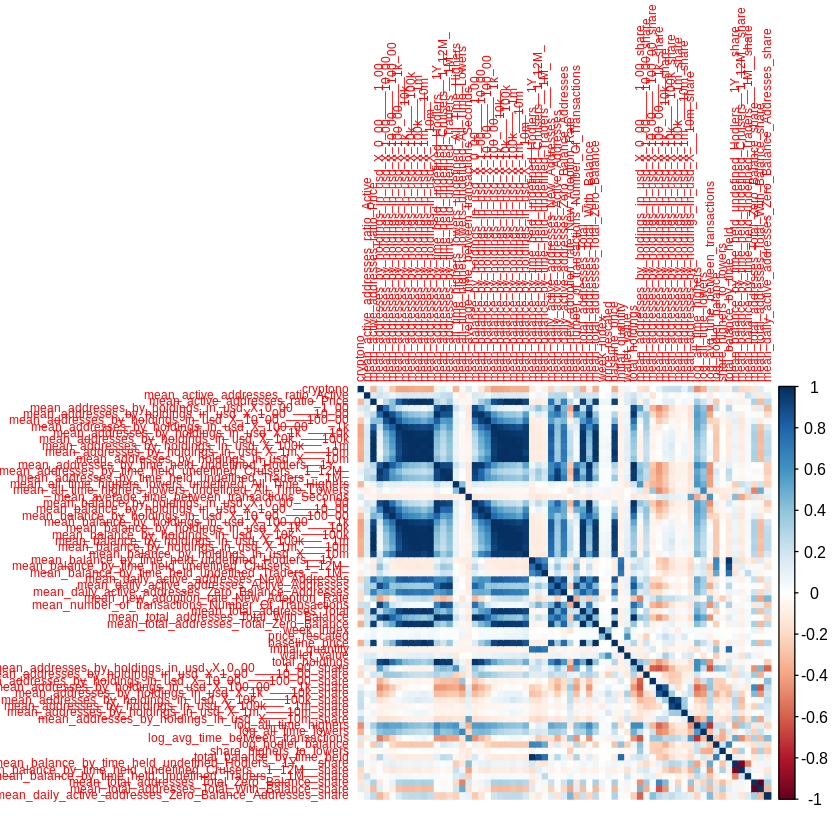

In [ ]:
# Calculate correlation matrix for all numeric predictors in the dataset
# Exclude non-numeric columns to get correlations only between numeric predictors
numeric_df <- df %>% select(where(is.numeric))
cor_matrix <- cor(numeric_df, use = "complete.obs")

# Visualize the correlation matrix to see how predictors correlate
corrplot(cor_matrix, method = "color", tl.cex = 0.6)


# Set the initial predictors list
predictors_list <- c(
  "mean_active_addresses_ratio_Active"
)

# Define a threshold for low correlation (adjust as necessary)
cor_threshold <- 0.7

# Function to add predictors with low correlation to existing predictors_list
add_predictors <- function(cor_matrix, predictors_list, cor_threshold) {
  for (col in colnames(cor_matrix)) {
    if (col %in% predictors_list) next  # Skip if already in predictors_list

    # Calculate maximum absolute correlation of this column with predictors in predictors_list
    max_cor <- max(abs(cor_matrix[col, predictors_list]), na.rm = TRUE)

    # Add to predictors_list if maximum correlation is below threshold
    if (max_cor < cor_threshold) {
      predictors_list <- c(predictors_list, col)
    }
  }
  return(predictors_list)
}

# Apply the function to extend the predictors_list
predictors_list <- add_predictors(cor_matrix, predictors_list, cor_threshold)

# Check the extended predictors_list
print(predictors_list)

In [ ]:
df <- read.csv("/content/sample_data/2024_recoded_rescaled.csv_rescaled.csv")

In [ ]:
# New list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_1m____10m_share",
  "mean_addresses_by_holdings_in_usd_X___10m_share",
  "log_all_time_highers",
  "log_all_time_lowers",
  "mean_daily_active_addresses_Zero_Balance_Addresses_share",
  "log_hodler_balance",
  "mean_balance_by_time_held_undefined_Hodlers__1Y___share",
  "mean_balance_by_time_held_undefined_Traders___1M__share",
  "mean_new_adoption_rate_New_Adoption_Rate"
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 36.29367 

solution.v:
 0.4087758 0.0786545 0.02549128 0.01036564 0.0705358 0.157865 0.0001681032 0.005106448 0.1855817 0.05745583 

solution.w:
 0.3068321 0.0000000217 0.0000000775 0.0000000999 0.0000001632 0.0000000388 0.1096916 0.0000000931 0.0000000559 0.0000000871 0.0000000154 0.0000028804 0.0000000973 0.0000000985 0.0000001106 0.0000001844 0.0000001448 0.0000000244 0.1597714 0.0000002722 0.03698172 0.0000001098 0.3867186 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.014
mean_addresses_by_holdings_in_usd_X_1m____10m_share        0.153     0.074
mean_addresses_by_holdings_in_usd_X___10m_share            0.014     0.048
log_all_time_highers                                      13.631    

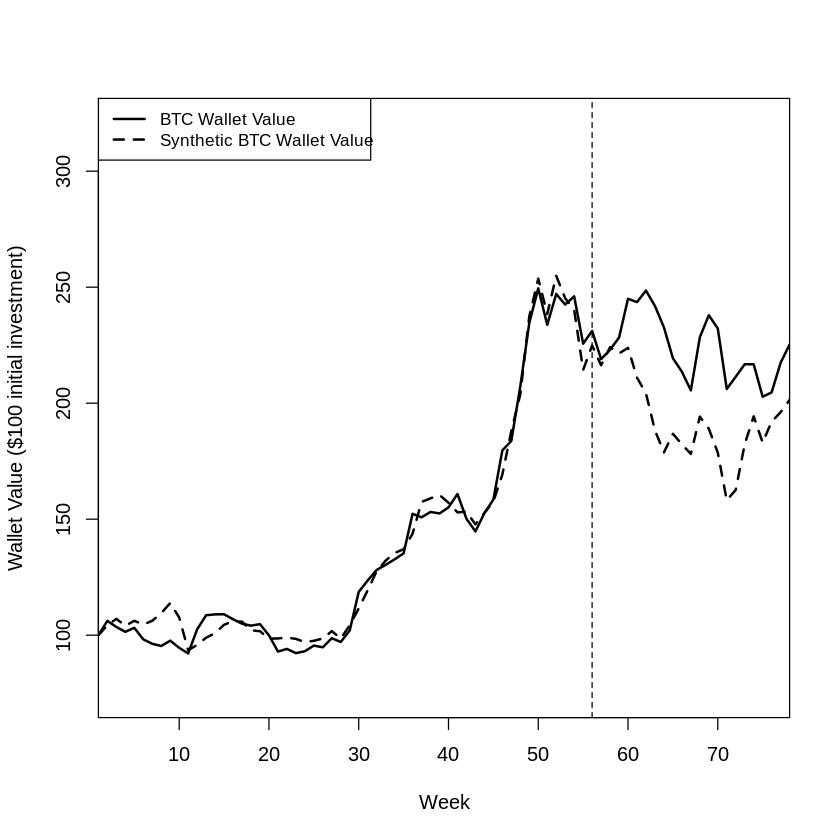

In [ ]:
# Define the key dates
#start_date <- as.Date("2023-04-02")  # Week 1
#halving_date <- as.Date("2024-04-21")  # Week 56
#end_date <- as.Date("2024-09-22")  # Week 78

# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## Placebo in time: 10 weeks earlier


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 26.90901 

solution.v:
 0.3318144 0.05551697 0.2051851 0.02701188 0.03181432 0.107124 0.001677152 0.05857494 0.003113533 0.0458171 0.03716647 0.09518408 

solution.w:
 0.004215315 0.0000001491 0.0000000687 0.0000000226 0.0000000727 0.0000001097 0.1098919 0.0000000502 0.0000000277 0.0000000249 0.0000000135 0.2359283 0.0000000208 0.0000000561 0.0000001513 0.0000000535 0.0000000397 0.0000001172 0.0000000243 0.0000000378 0.08618099 0.000000056 0.5637823 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.019     0.014
mean_addresses_by_holdings_in_usd_X_10_00____100_00_share  24.869    14.330
mean_addresses_by_holdings_in_usd_X_1m____10m_share         0.145     0.071
mean_addresses_by_holdings_in_usd_X___10m

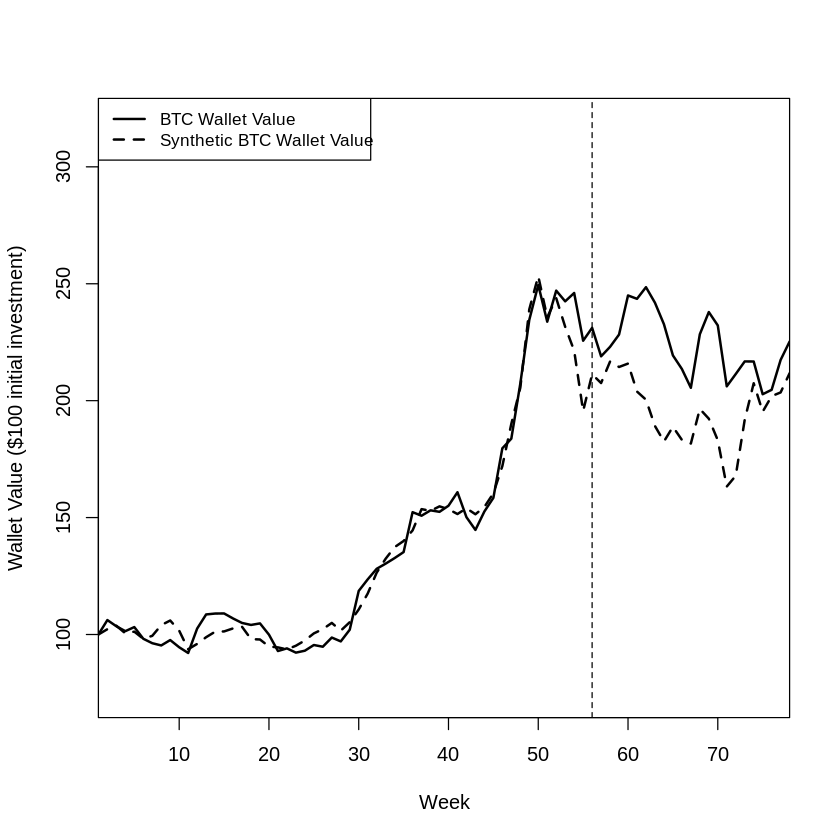

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:46)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56, #47
       lty = 2)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 712.8698 

solution.v:
 0.7614164 0.01219857 0.00769018 0.0003665026 0.0000583336 0.0002777931 0.0003929829 0.1417384 0.05650988 0.01858102 0.0003654642 0.0004044666 

solution.w:
 0.8155601 0.1844381 0.0000000171 0.00000002 0.0000000211 0.0000000143 0.0000000204 0.0000000127 0.0000000164 0.0000000166 0.0000000144 0.0000013996 0.000000023 0.0000000242 0.0000000238 0.0000000074 0.0000000165 0.0000000503 0.0000000096 0.0000000578 0.0000000136 0.0000000167 0.0000000313 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.020     0.017
mean_addresses_by_holdings_in_usd_X_10_00____100_00_share   2.577    24.956
mean_addresses_by_holdings_in_usd_X_1m____10m_share         0.000     0.129
mean_addresses_by_holdin

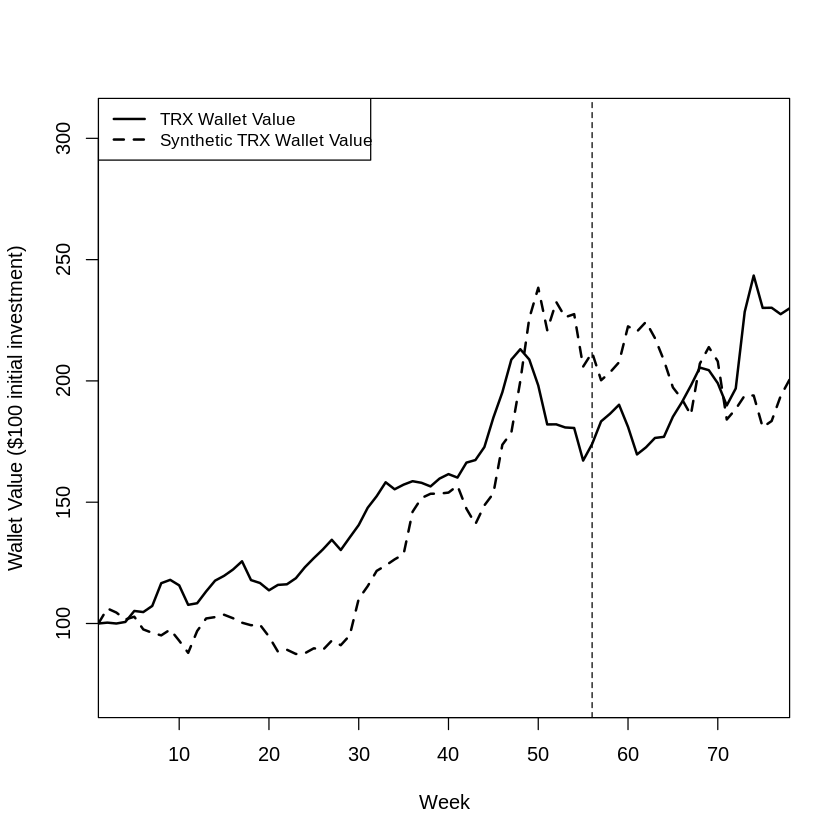

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:78)

all_controls <- c(1:25) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 26,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("TRX Wallet Value", "Synthetic TRX Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)